# Load ds005514 and start training (see below to read presaved data)

In [386]:
from eegdash import EEGDash
from eegdash.data_utils import RawEEGDash

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.find({'dataset': 'ds005514', 'task': 'RestingState'})
records = records[0:10]

print("number of records: ", len(records))
print("first record: ", records[0]) # current call




number of records:  10
first record:  {'_id': ObjectId('6789a3c766ea5ef303140d0c'), 'schema_ref': 'eeg_signal', 'data_name': 'ds005514_sub-NDARRW481GFE_task-RestingState_eeg.set', 'dataset': 'ds005514', 'bidspath': 'ds005514/sub-NDARRW481GFE/eeg/sub-NDARRW481GFE_task-RestingState_eeg.set', 'subject': 'NDARRW481GFE', 'task': 'RestingState', 'session': '', 'run': '', 'sampling_frequency': 500, 'modality': 'EEG', 'has_file': True, 'version_timestamp': 0, 'time_of_save': 1739409119098056, 'time_of_removal': None, 'channel_names': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 

In [387]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {'M': int(0), 'F': int(1)}

allEEGDash = []
records[0]
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(RawEEGDash(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False), target_name='genderbin')
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'genderbin': gender_to_label[record['participantinfo']['gender']], 'subject': record['subject']})
    allEEGDash.append(eegdash)


/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:131: UserWarning: 'genderbin' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [388]:
eegdash_braindecode = BaseConcatDataset(allEEGDash[:6])

In [389]:
import numpy as np

res = eegdash_braindecode.description
res

,age,gender,genderbin,subject
0,5.7012,M,0,NDARRW481GFE
1,13.5951,M,0,NDARTE553VC1
2,12.0696,F,1,NDARFJ488VPT
3,10.7882,F,1,NDARHT403JJJ
4,12.5762,M,0,NDARYW170CAA
5,10.0025,F,1,NDARYE017HZA


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[ 2402.36499023,  2358.11035156,  2292.43237305, ...,
        -3395.13867188, -3489.63623047, -3587.44360352]]), array([ 10.   ,  10.002,  10.004, ..., 445.466, 445.468, 445.47 ]))
-3617.61279296875 4021.9267578125


/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


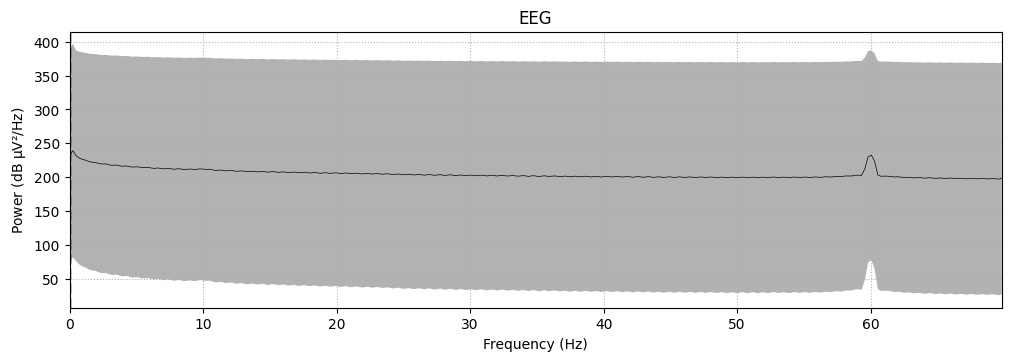

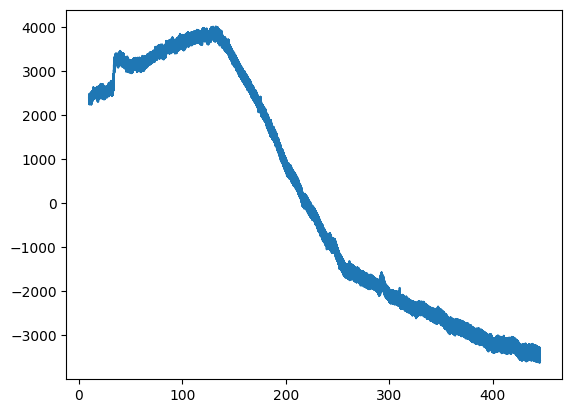

In [390]:
import matplotlib.pyplot as plt
import numpy as np
raw = eegdash_braindecode.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

In [391]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

preprocessors = [   
    Preprocessor("filter", l_freq=1, h_freq=55),
    Preprocessor("resample", sfreq=125)
]

preprocess(eegdash_braindecode, preprocessors, n_jobs=-1)

windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=614,
        window_stride_samples=1000, drop_last_window=True,
        preload=False) 

Reading 0 ... 222735  =      0.000 ...   445.470 secs...
Reading 0 ... 175584  =      0.000 ...   351.168 secs...
Reading 0 ... 188762  =      0.000 ...   377.524 secs...
Reading 0 ... 195236  =      0.000 ...   390.472 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Reading 0 ... 174585  =      0.000 ...   349.170 secs...
Reading 0 ... 187113  =      0.000 ...   374.226 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


In [ ]:
import os
# save all the data
if False:
    os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
    windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)
else:
    print('NOTHING WAS DONE. CHANGE THE CONDITIONAL STATEMENT.')

# Start here to load presaved data

In [1]:
# check if windows_ds is a variable in the workspace and delete it
if 'windows_ds' in locals():
    del windows_ds

In [3]:
# if you run this cell as it loads all the data from disk

import os
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)


Loading data from disk


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

random_state = 42
subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [5]:
from braindecode.datasets import BaseDataset, BaseConcatDataset

train_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_train])
val_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_valid])
test_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_test])

train_ds2 = [[ds[0].reshape(1, ds[0].shape[0], ds[0].shape[1]), ds[1], ds[2]] for ds in train_ds]
test_ds2  = [[ds[0].reshape(1, ds[0].shape[0], ds[0].shape[1]), ds[1], ds[2]] for ds in test_ds]

train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)

print("Shape of train_ds[0][0]:", train_ds[0][0].shape)
print("Shape of train_ds2[0][0]:", train_ds2[0][0].shape)


Shape of train_ds[0][0]: (129, 614)
Shape of train_ds2[0][0]: (1, 129, 614)


In [6]:
from torch.utils.data import DataLoader
import torch
# Add data normalization

def custom_collate_fn(batch):
    # Assuming each element in the batch is a tuple (data, target)
    data, target, sz = zip(*batch)
    data = torch.stack([torch.tensor(d, dtype=torch.float32) for d in data])
    # data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
    target = torch.tensor(target, dtype=torch.long)
    return data, target

train_loader2 = DataLoader(train_ds, batch_size=32, collate_fn=custom_collate_fn) # train_loader abbove do not work for some reason
test_loader2  = DataLoader(test_ds, batch_size=32, collate_fn=custom_collate_fn)

In [7]:
dataiter = iter(train_ds)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
label

1

In [10]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

# re-import models_dung_2021
import importlib
import models_dung_2021
importlib.reload(models_dung_2021)  # This ensures we get the latest version
from models_dung_2021 import (create_model_original_129_614, create_model_vgg16)

cuda = torch.cuda.is_available()  # check if CUDA GPU is available
mps = torch.backends.mps.is_available()  # check if MPS (Apple GPU) is available

if cuda:
    device = torch.device("cuda")
elif mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if cuda:
    torch.backends.cudnn.benchmark = True
    
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_ds[0][0].shape[0]
input_window_samples = windows_ds[0][0].shape[1]

model_name = 'shallow' #'shallow' #'original' #'vgg16'
if model_name == 'vgg16':
    model = create_model_vgg16((1, 1, 129, 614))
    print(summary(model, input_size=(1, 1, 129, 614), col_names=["input_size", "output_size", "num_params", "kernel_size"])) # puts the model back on CPU
elif model_name == 'original':
    model = create_model_original_129_614()
    print(summary(model, input_size=(1, 1, 129, 614), col_names=["input_size", "output_size", "num_params", "kernel_size"])) # puts the model back on CPU
else:
    model = ShallowFBCSPNet(
        n_channels,
        n_classes,
        input_window_samples=input_window_samples,
        final_conv_length="auto",
    )
    print(model)

# Send model to GPU
if cuda:
    model.cuda()
    
model.to(device)
print(f"Model device: {next(model.parameters()).device}")


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 129, 614]             [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 129, 614]             [1, 129, 614, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 129, 614, 1]          [1, 1, 614, 129]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 614, 129]          [1, 40, 590, 1]           207,440                   --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 590, 1]           [1, 40, 590, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 590, 1]           [1, 40, 590, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 590, 1]           [1, 40, 35, 1]            --                        [75, 1]
├─Express

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming 'model' is your ShallowFBCSPNet instance
# Assuming 'dataloader' is your DataLoader instance
def normalize_data(data):
    return (data - data.mean()) / (data.std() + 1e-8)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move all the training data to the device

# Training loop
n_epochs = 10  # Number of epochs
for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target, sz) in enumerate(train_loader):
        # Move data to the appropriate device (e.g., GPU if available)
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
        # print(f"Model device: {next(model.parameters()).device}")
        # print(f"Data device: {data.device}, Data type: {data.dtype}")
        # print(f"Target device: {target.device}, Target type: {target.dtype}")        
        # print(data.shape)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Compute loss
        loss = F.cross_entropy(outputs, target)
               
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader2):.4f}")

Epoch [1/10], Loss: 2.1493
Epoch [2/10], Loss: 1.4800
Epoch [3/10], Loss: 1.1120
Epoch [4/10], Loss: 0.9068
Epoch [5/10], Loss: 0.6751
Epoch [6/10], Loss: 0.4992
Epoch [7/10], Loss: 0.3783
Epoch [8/10], Loss: 0.2976
Epoch [9/10], Loss: 0.3003
Epoch [10/10], Loss: 0.2571


In [12]:
# test the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for data, target in test_loader2:
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")
        

Accuracy: 64.46%


In [398]:
# perform cross-validation randonly selectings windows_ds among len(windows_ds)
from sklearn.model_selection import KFold
import copy
               
kf = KFold(n_splits=5, shuffle=True)
model_copy = copy.deepcopy(model)

for train_index, val_index in kf.split(windows_ds):
    X = torch.FloatTensor(np.array([windows_ds[i][0] for i in train_index]))  # Convert list of arrays to single tensor
    y = torch.LongTensor(np.array(windows_ds.get_metadata()['target']))     # Convert targets to tensor
    dataset_train = TensorDataset(X, y[train_index])
    dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True)

    X = torch.FloatTensor(np.array([windows_ds[i][0] for i in val_index]))  # Convert list of arrays to single tensor
    y = torch.LongTensor(np.array(windows_ds.get_metadata()['target']))     # Convert targets to tensor
    dataset_val = TensorDataset(X, y[val_index])
    dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

    # reset model parameters
    model = copy.deepcopy(model_copy)
    
    # Training loop
    n_epochs = 10  # Number of epochs
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(dataloader_train):
            # Move data to the appropriate device (e.g., GPU if available)
            data = normalize_data(data)
            if model_name == 'vgg16' or model_name == 'original':
                data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
            data, target = data.to(device), target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            
            # Compute loss
            loss = F.cross_entropy(outputs, target)
                
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            running_loss += loss.item()
            
        #print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader2):.4f}")    
        
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(dataloader_val):
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data, target = data.to(device), target.to(device)
        data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
            
    print(f"Validation accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 10.6608
Epoch [2/10], Loss: 12.4258
Epoch [3/10], Loss: 10.7558
Epoch [4/10], Loss: 8.3864
Epoch [5/10], Loss: 7.6230
Epoch [6/10], Loss: 12.7296
Epoch [7/10], Loss: 11.7815
Epoch [8/10], Loss: 10.1884
Epoch [9/10], Loss: 9.6745
Epoch [10/10], Loss: 9.3067
Validation accuracy: 58.62%
Epoch [1/10], Loss: 10.4266
Epoch [2/10], Loss: 9.3364
Epoch [3/10], Loss: 8.4209
Epoch [4/10], Loss: 12.1507
Epoch [5/10], Loss: 11.4463
Epoch [6/10], Loss: 9.6799
Epoch [7/10], Loss: 9.9175
Epoch [8/10], Loss: 9.1513
Epoch [9/10], Loss: 6.6600
Epoch [10/10], Loss: 11.8379
Validation accuracy: 55.17%
Epoch [1/10], Loss: 10.6581
Epoch [2/10], Loss: 10.8381
Epoch [3/10], Loss: 9.5288
Epoch [4/10], Loss: 9.4913
Epoch [5/10], Loss: 9.1316
Epoch [6/10], Loss: 8.7235
Epoch [7/10], Loss: 9.6968
Epoch [8/10], Loss: 10.1474
Epoch [9/10], Loss: 11.5412
Epoch [10/10], Loss: 9.3786
Validation accuracy: 54.39%
Epoch [1/10], Loss: 7.2465
Epoch [2/10], Loss: 9.6884
Epoch [3/10], Loss: 6.2793
Epoch [4

In [294]:
windows_ds[84]

(array([[  13.957573 ,   -2.556084 ,   27.822443 , ...,    7.5104256,
           -7.5957413,   12.91138  ],
        [  87.06689  ,  -79.744804 ,   95.761734 , ...,  -74.99222  ,
           73.82263  ,  -65.78684  ],
        [-149.94324  ,  151.19386  , -141.35626  , ...,  178.22064  ,
         -180.66707  ,  188.04073  ],
        ...,
        [  58.14723  ,  -56.004196 ,   86.285164 , ...,  -84.40123  ,
           84.80968  , -100.70467  ],
        [  66.39647  ,  -51.849937 ,   97.117775 , ...,  -88.897766 ,
           92.31235  , -101.10488  ],
        [  66.11     ,  -52.419735 ,   94.67511  , ...,  -86.46298  ,
           89.63176  ,  -99.49088  ]], dtype=float32),
 0,
 [40, 40000, 40614])

In [295]:
windows_ds.datasets[1][40]

(array([[  13.957573 ,   -2.556084 ,   27.822443 , ...,    7.5104256,
           -7.5957413,   12.91138  ],
        [  87.06689  ,  -79.744804 ,   95.761734 , ...,  -74.99222  ,
           73.82263  ,  -65.78684  ],
        [-149.94324  ,  151.19386  , -141.35626  , ...,  178.22064  ,
         -180.66707  ,  188.04073  ],
        ...,
        [  58.14723  ,  -56.004196 ,   86.285164 , ...,  -84.40123  ,
           84.80968  , -100.70467  ],
        [  66.39647  ,  -51.849937 ,   97.117775 , ...,  -88.897766 ,
           92.31235  , -101.10488  ],
        [  66.11     ,  -52.419735 ,   94.67511  , ...,  -86.46298  ,
           89.63176  ,  -99.49088  ]], dtype=float32),
 0,
 [40, 40000, 40614])

In [318]:
# Assuming 'test_loader' is your DataLoader for the test dataset

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for data, target in test_loader2:
        # move to device
        data, target = data.to(device), target.to(device)  
        data = normalize_data(data)
        if model_name == 'vgg16' or model_name == 'original':
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

EinopsError: Shape mismatch, 614 != 1

In [209]:
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

if model_name in ['vgg16', 'original']:
    dataset = train_ds2 # does not work with the model below
else:
    dataset = train_ds

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2
  
clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    dataset=dataset,
    max_epochs=n_epochs,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_ds,y=np.array(train_ds.get_metadata()['target']))

# evaluated the model after training
# y_test = test_ds.get_metadata().target
# test_acc = clf.score(test_ds, y=y_test)
# print(f"Test acc: {(test_acc * 100):.2f}%")

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.6690       10.9828  0.0006  0.6172
      2            0.6690       10.3273  0.0000  0.4974


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ============================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 129, 614]             [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 129, 614]             [1, 129, 614, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 129, 614, 1]          [1, 1, 614, 129]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 614, 129]          [1, 40, 590, 1]           207,440                   --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 590, 1]           [1, 40, 590, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5      [1, 40, 590, 1]           [1, 40, 590, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                  [1, 40, 590, 1]           [1, 40, 35, 1]            --                        [75, 1]
  ├─Expression (pool_nonlin_exp): 1-7      [1, 40, 35, 1]            [1, 40, 35, 1]            --                        --
  ├─Dropout (drop): 1-8                    [1, 40, 35, 1]            [1, 40, 35, 1]            --                        --
  ├─Sequential (final_layer): 1-9          [1, 40, 35, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1     [1, 40, 35, 1]            [1, 2, 1, 1]              2,802                     [35, 1]
  │    └─LogSoftmax (logsoftmax): 2-2      [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3         [1, 2, 1, 1]              [1, 2]                    --                        --
  ============================================================================================================================================
  Total params: 210,322
  Trainable params: 210,322
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  ============================================================================================================================================
  Input size (MB): 0.32
  Forward/backward pass size (MB): 0.19
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.52
  ============================================================================================================================================,
)

In [210]:
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier

from sklearn.model_selection import KFold, cross_val_score

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    max_epochs=n_epochs,
)

train_val_split = KFold(n_splits=5, shuffle=False)
# By setting n_jobs=-1, cross-validation is performed
# with all the processors, in this case the output of the training
# process is not printed sequentially
cv_results = cross_val_score(
    clf, train_ds, test_ds, scoring="accuracy", cv=train_val_split, n_jobs=1
)
print(
    f"Validation accuracy: {np.mean(cv_results * 100):.2f}"
    f"+-{np.std(cv_results * 100):.2f}%"
)

NameError: name 'X_train' is not defined

In [ ]:

train_ds2[0][0]. shape

(1, 129, 614)

In [153]:
np.array(train_ds.get_metadata()['target'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [52]:
model = train(model, train_loader, optimizer, epochs=1)


NameError: name 'train' is not defined

In [49]:
gender_to_label = {'M': 0, 'F': 1}
gender_to_label['M', 'F']

KeyError: ('M', 'F')